In [3]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import random
from sklearn.utils import shuffle
import scipy.stats
from sklearn.model_selection import train_test_split

In [4]:
import time
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical

In [5]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [6]:
train_file = 'train_mitbih_new.csv'
test_file = 'test_mitbih_new.csv'
data_train = pd.read_csv(train_file, header=0)
data_test = pd.read_csv(test_file, header=0)
print(data_train.shape)
print(data_test.shape)

x_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
x_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, shuffle=True)

(22330, 188)
(5586, 188)


In [7]:
print(x_train.shape, y_train.shape)
print(x_validate.shape, y_validate.shape)
print(x_test.shape, y_test.shape)

(16747, 187, 1) (16747, 5)
(5583, 187, 1) (5583, 5)
(5586, 187, 1) (5586, 5)


In [8]:
def cnn_model_1(x_train, y_train, n_filters):
    n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    model = keras.Sequential(
        [
            keras.Input(shape=(n_timesteps,n_features)),
            layers.Conv1D(filters=n_filters, kernel_size=1, activation='relu'),
            #layers.Conv1D(filters=n_filters, kernel_size=1, activation='relu'),
            layers.Dropout(0.1),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    return model

In [9]:
filter_arr = [10, 20, 30, 50, 100, 200, 500, 1000]
BATCH_SIZE = 32     # Typical values are 8, 16 or 32
NUM_EPOCHS = 30
val_acc_arr = []
pred_acc_arr = []
time_arr = []
keras.backend.clear_session()
for n_filters in filter_arr:
    model = cnn_model_1(x_train, y_train, n_filters)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    start = time.time()
    history = model.fit(
            x_train,y_train,
            steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=(x_validate,y_validate),
            validation_steps=x_validate.shape[0]//BATCH_SIZE)
    
    print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    end = time.time()
    predictions = model.predict(x_test, verbose=0,batch_size=32)
    
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    
    # Print print prediction accuracy
    print('Num filters: ',n_filters)
    print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    print('Time in sec: ' ,end-start)
    val_acc_arr.append(history.history['val_accuracy'][-1])
    pred_acc_arr.append(accuracy_score(y_test_act, y_pred))
    time_arr.append(end-start)
    
    keras.backend.clear_session()
    

2024-04-26 21:31:14.638644: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 10)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 930)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        93,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,625 (365.72 KB)

 Trainable params: 93,625 (365.72 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6453 - loss: 0.9354

2024-04-26 21:31:16.365566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6480 - loss: 0.9292 - val_accuracy: 0.8212 - val_loss: 0.5319
Epoch 2/30
 77/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.5553

2024-04-26 21:31:16.617687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8189 - loss: 0.5203 - val_accuracy: 0.8635 - val_loss: 0.4044
Epoch 3/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8788 - loss: 0.3493

2024-04-26 21:31:17.645763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:17.797995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8568 - loss: 0.4174 - val_accuracy: 0.8676 - val_loss: 0.3675
Epoch 4/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8182 - loss: 0.4165

2024-04-26 21:31:18.838449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:18.988949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - loss: 0.3642 - val_accuracy: 0.8804 - val_loss: 0.3369
Epoch 5/30


2024-04-26 21:31:20.047531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:20.194158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8856 - loss: 0.3241 - val_accuracy: 0.9004 - val_loss: 0.3020
Epoch 6/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9091 - loss: 0.2959

2024-04-26 21:31:21.221027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:21.374977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8919 - loss: 0.3093 - val_accuracy: 0.9026 - val_loss: 0.2887
Epoch 7/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9394 - loss: 0.2900

2024-04-26 21:31:22.355168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:22.500074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9026 - loss: 0.2875 - val_accuracy: 0.9069 - val_loss: 0.2734
Epoch 8/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9091 - loss: 0.2003

2024-04-26 21:31:23.502128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:23.656635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9099 - loss: 0.2664 - val_accuracy: 0.9122 - val_loss: 0.2641
Epoch 9/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9091 - loss: 0.2406

2024-04-26 21:31:24.697911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:24.846778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9127 - loss: 0.2534 - val_accuracy: 0.9087 - val_loss: 0.2713
Epoch 10/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8485 - loss: 0.4639

2024-04-26 21:31:25.884190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:26.031186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9193 - loss: 0.2428 - val_accuracy: 0.9189 - val_loss: 0.2465
Epoch 11/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8788 - loss: 0.1943

2024-04-26 21:31:27.053152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:27.198666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9221 - loss: 0.2337 - val_accuracy: 0.9198 - val_loss: 0.2433
Epoch 12/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9394 - loss: 0.1247

2024-04-26 21:31:28.221631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:28.371752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9259 - loss: 0.2186 - val_accuracy: 0.9162 - val_loss: 0.2568
Epoch 13/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9091 - loss: 0.2062

2024-04-26 21:31:29.378761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:29.530862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9293 - loss: 0.2125 - val_accuracy: 0.9180 - val_loss: 0.2409
Epoch 14/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8788 - loss: 0.3127

2024-04-26 21:31:30.546560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:30.686048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9277 - loss: 0.2143 - val_accuracy: 0.9275 - val_loss: 0.2202
Epoch 15/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9091 - loss: 0.3182

2024-04-26 21:31:31.690642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:31.846794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9318 - loss: 0.2073 - val_accuracy: 0.9219 - val_loss: 0.2311
Epoch 16/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9394 - loss: 0.1826

2024-04-26 21:31:32.937618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:33.085285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9331 - loss: 0.1871 - val_accuracy: 0.9271 - val_loss: 0.2170
Epoch 17/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9697 - loss: 0.0788

2024-04-26 21:31:34.176732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:34.328104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9365 - loss: 0.1891 - val_accuracy: 0.9242 - val_loss: 0.2234
Epoch 18/30


2024-04-26 21:31:35.469261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:35.640479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9415 - loss: 0.1756 - val_accuracy: 0.9260 - val_loss: 0.2166
Epoch 19/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 1.0000 - loss: 0.0961

2024-04-26 21:31:36.695967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:36.844009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9403 - loss: 0.1800 - val_accuracy: 0.9258 - val_loss: 0.2160
Epoch 20/30


2024-04-26 21:31:38.015968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:38.183339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9426 - loss: 0.1653 - val_accuracy: 0.9280 - val_loss: 0.2191
Epoch 21/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 1.0000 - loss: 0.0644

2024-04-26 21:31:39.336692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:39.483835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9434 - loss: 0.1667 - val_accuracy: 0.9332 - val_loss: 0.2123
Epoch 22/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9697 - loss: 0.0964

2024-04-26 21:31:40.578109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:40.726455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9443 - loss: 0.1682 - val_accuracy: 0.9284 - val_loss: 0.2132
Epoch 23/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9091 - loss: 0.2446

2024-04-26 21:31:41.840751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:41.987700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9443 - loss: 0.1650 - val_accuracy: 0.9232 - val_loss: 0.2154
Epoch 24/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 1.0000 - loss: 0.0307

2024-04-26 21:31:43.020131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:43.169872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9472 - loss: 0.1556 - val_accuracy: 0.9361 - val_loss: 0.2040
Epoch 25/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9697 - loss: 0.1078

2024-04-26 21:31:44.204500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:44.352999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9492 - loss: 0.1515 - val_accuracy: 0.9348 - val_loss: 0.2085
Epoch 26/30


2024-04-26 21:31:45.508599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:45.682003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9498 - loss: 0.1489 - val_accuracy: 0.9310 - val_loss: 0.2122
Epoch 27/30


2024-04-26 21:31:46.945672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:47.113995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9491 - loss: 0.1503 - val_accuracy: 0.9323 - val_loss: 0.2145
Epoch 28/30


2024-04-26 21:31:48.240565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:48.403418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9502 - loss: 0.1469 - val_accuracy: 0.9339 - val_loss: 0.2029
Epoch 29/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 1.0000 - loss: 0.0670

2024-04-26 21:31:49.475029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:49.619191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9542 - loss: 0.1351 - val_accuracy: 0.9359 - val_loss: 0.2086
Epoch 30/30


2024-04-26 21:31:50.693449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:50.857859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9550 - loss: 0.1371 - val_accuracy: 0.9334 - val_loss: 0.2094


2024-04-26 21:31:52.038184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:52.206446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.933
Num filters:  10
Prediction accuracy: 0.924
Time in sec:  37.53211545944214


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 20)        │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1860)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       186,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,645 (729.08 KB)

 Trainable params: 186,645 (729.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
497/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6342 - loss: 0.9467

2024-04-26 21:31:54.674536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6382 - loss: 0.9382 - val_accuracy: 0.8117 - val_loss: 0.5661
Epoch 2/30
 66/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8026 - loss: 0.6003

2024-04-26 21:31:54.987737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8122 - loss: 0.5529

2024-04-26 21:31:56.287184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8128 - loss: 0.5510 - val_accuracy: 0.8601 - val_loss: 0.4145
Epoch 3/30
 62/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8652 - loss: 0.4046

2024-04-26 21:31:56.502424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.4282

2024-04-26 21:31:58.129493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:58.327180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8508 - loss: 0.4277 - val_accuracy: 0.8741 - val_loss: 0.3828
Epoch 4/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8710 - loss: 0.3759 - val_accuracy: 0.8843 - val_loss: 0.3408
Epoch 5/30


2024-04-26 21:31:59.485590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:31:59.663607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8815 - loss: 0.3471 - val_accuracy: 0.8800 - val_loss: 0.3389
Epoch 6/30


2024-04-26 21:32:00.913302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:01.094741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8857 - loss: 0.3305

2024-04-26 21:32:02.385665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8858 - loss: 0.3302 - val_accuracy: 0.8915 - val_loss: 0.3008
Epoch 7/30
 67/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8829 - loss: 0.3158

2024-04-26 21:32:02.590559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8917 - loss: 0.3077 - val_accuracy: 0.8877 - val_loss: 0.3206
Epoch 8/30


2024-04-26 21:32:03.759952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:03.922112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


489/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9012 - loss: 0.2889

2024-04-26 21:32:05.398531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:05.596056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9010 - loss: 0.2890 - val_accuracy: 0.8943 - val_loss: 0.3085
Epoch 9/30
502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9056 - loss: 0.2844

2024-04-26 21:32:07.048864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9056 - loss: 0.2841 - val_accuracy: 0.9047 - val_loss: 0.2769
Epoch 10/30
 37/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9211 - loss: 0.2407

2024-04-26 21:32:07.261564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9119 - loss: 0.2614

2024-04-26 21:32:08.989849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9119 - loss: 0.2613 - val_accuracy: 0.9045 - val_loss: 0.2821
Epoch 11/30
 43/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9009 - loss: 0.3206

2024-04-26 21:32:09.221706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


492/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9137 - loss: 0.2625

2024-04-26 21:32:10.699447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9139 - loss: 0.2617 - val_accuracy: 0.9144 - val_loss: 0.2522
Epoch 12/30
 58/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9100 - loss: 0.2495

2024-04-26 21:32:10.904788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.2480 - val_accuracy: 0.9144 - val_loss: 0.2456
Epoch 13/30


2024-04-26 21:32:12.182812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:12.353292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9250 - loss: 0.2223 - val_accuracy: 0.9131 - val_loss: 0.2521
Epoch 14/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9394 - loss: 0.3025

2024-04-26 21:32:13.510060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:13.667607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9229 - loss: 0.2235 - val_accuracy: 0.9189 - val_loss: 0.2387
Epoch 15/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9091 - loss: 0.1567

2024-04-26 21:32:14.787816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:14.945262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9305 - loss: 0.2040 - val_accuracy: 0.9223 - val_loss: 0.2295
Epoch 16/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8788 - loss: 0.2263

2024-04-26 21:32:16.031583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:16.189923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


487/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9346 - loss: 0.1955

2024-04-26 21:32:17.616567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:17.817226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9343 - loss: 0.1960 - val_accuracy: 0.9147 - val_loss: 0.2458
Epoch 17/30
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9316 - loss: 0.2029 - val_accuracy: 0.9176 - val_loss: 0.2370
Epoch 18/30


2024-04-26 21:32:18.952044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:19.114785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9321 - loss: 0.1950 - val_accuracy: 0.9242 - val_loss: 0.2329
Epoch 19/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9697 - loss: 0.3426

2024-04-26 21:32:20.274628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:20.433241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9366 - loss: 0.1881 - val_accuracy: 0.9294 - val_loss: 0.2144
Epoch 20/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9394 - loss: 0.1616

2024-04-26 21:32:21.582229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:21.737798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9428 - loss: 0.1739 - val_accuracy: 0.9280 - val_loss: 0.2144
Epoch 21/30


2024-04-26 21:32:22.850367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:23.007711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9437 - loss: 0.1636 - val_accuracy: 0.9246 - val_loss: 0.2240
Epoch 22/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 1.0000 - loss: 0.0281

2024-04-26 21:32:24.135678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:24.293731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9395 - loss: 0.1746 - val_accuracy: 0.9237 - val_loss: 0.2250
Epoch 23/30


2024-04-26 21:32:25.335609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:25.503350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9439 - loss: 0.1663 - val_accuracy: 0.9285 - val_loss: 0.2195
Epoch 24/30


2024-04-26 21:32:26.661818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:26.823118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9438 - loss: 0.1629 - val_accuracy: 0.9251 - val_loss: 0.2276
Epoch 25/30


2024-04-26 21:32:27.887589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:28.047966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.1657

2024-04-26 21:32:29.174579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9423 - loss: 0.1657 - val_accuracy: 0.9328 - val_loss: 0.2064
Epoch 26/30
 71/523 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.1299

2024-04-26 21:32:29.381095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1515 - val_accuracy: 0.9307 - val_loss: 0.2177
Epoch 27/30


2024-04-26 21:32:30.537418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:30.717272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9454 - loss: 0.1596 - val_accuracy: 0.9319 - val_loss: 0.2070
Epoch 28/30


2024-04-26 21:32:31.917740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:32.093032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9447 - loss: 0.1508 - val_accuracy: 0.9309 - val_loss: 0.2151
Epoch 29/30


2024-04-26 21:32:33.331507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:33.502113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9530 - loss: 0.1371 - val_accuracy: 0.9162 - val_loss: 0.2579
Epoch 30/30


2024-04-26 21:32:34.788843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:34.959603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9478 - loss: 0.1544 - val_accuracy: 0.9310 - val_loss: 0.2145


2024-04-26 21:32:36.072047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:36.244614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.931
Num filters:  20
Prediction accuracy: 0.925
Time in sec:  43.49021363258362


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 30)        │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2790)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       279,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,665 (1.07 MB)

 Trainable params: 279,665 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
493/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6552 - loss: 0.9139

2024-04-26 21:32:39.038717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6600 - loss: 0.9033 - val_accuracy: 0.8300 - val_loss: 0.5102
Epoch 2/30
 36/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8193 - loss: 0.5526

2024-04-26 21:32:39.328043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8273 - loss: 0.5047

2024-04-26 21:32:40.834801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8276 - loss: 0.5035 - val_accuracy: 0.8583 - val_loss: 0.4111
Epoch 3/30
 62/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8498 - loss: 0.4112

2024-04-26 21:32:41.046660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.4022

2024-04-26 21:32:42.396507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8597 - loss: 0.4015 - val_accuracy: 0.8771 - val_loss: 0.3555
Epoch 4/30
 57/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8741 - loss: 0.3848

2024-04-26 21:32:42.655847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


496/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8811 - loss: 0.3530

2024-04-26 21:32:44.232890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8812 - loss: 0.3524 - val_accuracy: 0.8881 - val_loss: 0.3259
Epoch 5/30
 58/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8748 - loss: 0.3678

2024-04-26 21:32:44.457361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8878 - loss: 0.3244 - val_accuracy: 0.8970 - val_loss: 0.3038
Epoch 6/30


2024-04-26 21:32:46.002435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:46.186533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


492/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8962 - loss: 0.3031

2024-04-26 21:32:47.611438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:47.810847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8963 - loss: 0.3027 - val_accuracy: 0.9058 - val_loss: 0.2770
Epoch 7/30
505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9028 - loss: 0.2872

2024-04-26 21:32:49.523756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:49.725835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9029 - loss: 0.2870 - val_accuracy: 0.9074 - val_loss: 0.2773
Epoch 8/30
494/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - loss: 0.2646

2024-04-26 21:32:51.416948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9108 - loss: 0.2645 - val_accuracy: 0.9094 - val_loss: 0.2667
Epoch 9/30
 47/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9288 - loss: 0.2224

2024-04-26 21:32:51.650217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


494/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9172 - loss: 0.2478

2024-04-26 21:32:53.394209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9171 - loss: 0.2481 - val_accuracy: 0.9027 - val_loss: 0.2784
Epoch 10/30
 28/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9052 - loss: 0.2409

2024-04-26 21:32:53.638958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9176 - loss: 0.2412

2024-04-26 21:32:55.421215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9177 - loss: 0.2412 - val_accuracy: 0.9113 - val_loss: 0.2722
Epoch 11/30
 30/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9107 - loss: 0.2570

2024-04-26 21:32:55.713219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.2362

2024-04-26 21:32:57.483741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9212 - loss: 0.2360 - val_accuracy: 0.9124 - val_loss: 0.2524
Epoch 12/30
 45/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9228 - loss: 0.2038

2024-04-26 21:32:57.711565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9252 - loss: 0.2169 - val_accuracy: 0.9226 - val_loss: 0.2381
Epoch 13/30


2024-04-26 21:32:59.241131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:32:59.426982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9286 - loss: 0.2150

2024-04-26 21:33:01.246049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9286 - loss: 0.2150 - val_accuracy: 0.9171 - val_loss: 0.2517
Epoch 14/30
 43/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9431 - loss: 0.2050

2024-04-26 21:33:01.586612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9332 - loss: 0.2040

2024-04-26 21:33:03.412652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9331 - loss: 0.2039 - val_accuracy: 0.9207 - val_loss: 0.2364
Epoch 15/30
 31/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9478 - loss: 0.1506

2024-04-26 21:33:03.706450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9335 - loss: 0.1960

2024-04-26 21:33:05.547176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9335 - loss: 0.1960 - val_accuracy: 0.9278 - val_loss: 0.2214
Epoch 16/30
 30/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9355 - loss: 0.1708

2024-04-26 21:33:05.797394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9380 - loss: 0.1831

2024-04-26 21:33:07.728894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9379 - loss: 0.1833 - val_accuracy: 0.9230 - val_loss: 0.2272
Epoch 17/30
 43/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9385 - loss: 0.1787

2024-04-26 21:33:07.980798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.1816

2024-04-26 21:33:09.907543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9374 - loss: 0.1817 - val_accuracy: 0.9258 - val_loss: 0.2206
Epoch 18/30
 43/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9424 - loss: 0.1567

2024-04-26 21:33:10.131879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9404 - loss: 0.1736

2024-04-26 21:33:12.065768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9403 - loss: 0.1738 - val_accuracy: 0.9239 - val_loss: 0.2222
Epoch 19/30
 30/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9495 - loss: 0.1506

2024-04-26 21:33:12.284144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9418 - loss: 0.1689

2024-04-26 21:33:14.097249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9418 - loss: 0.1690 - val_accuracy: 0.9246 - val_loss: 0.2344
Epoch 20/30
 39/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9530 - loss: 0.1492

2024-04-26 21:33:14.345778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.1623

2024-04-26 21:33:16.078339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9462 - loss: 0.1626 - val_accuracy: 0.9307 - val_loss: 0.2132
Epoch 21/30
 57/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9605 - loss: 0.1111

2024-04-26 21:33:16.316092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9485 - loss: 0.1509

2024-04-26 21:33:17.946307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9483 - loss: 0.1515 - val_accuracy: 0.9287 - val_loss: 0.2077
Epoch 22/30
 48/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9523 - loss: 0.1582

2024-04-26 21:33:18.195042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9448 - loss: 0.1620

2024-04-26 21:33:19.791824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9449 - loss: 0.1619 - val_accuracy: 0.9224 - val_loss: 0.2307
Epoch 23/30
 56/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9431 - loss: 0.1576

2024-04-26 21:33:20.084179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9465 - loss: 0.1539

2024-04-26 21:33:21.640525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:33:21.842141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9465 - loss: 0.1539 - val_accuracy: 0.9269 - val_loss: 0.2258
Epoch 24/30
500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9481 - loss: 0.1521

2024-04-26 21:33:23.344992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9480 - loss: 0.1521 - val_accuracy: 0.9251 - val_loss: 0.2254
Epoch 25/30
 33/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9486 - loss: 0.1412

2024-04-26 21:33:23.608973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


496/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - loss: 0.1465

2024-04-26 21:33:25.361470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9486 - loss: 0.1467 - val_accuracy: 0.9287 - val_loss: 0.2178
Epoch 26/30
 30/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9657 - loss: 0.1203

2024-04-26 21:33:25.623027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9547 - loss: 0.1374

2024-04-26 21:33:27.291818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:33:27.483678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9546 - loss: 0.1377 - val_accuracy: 0.9294 - val_loss: 0.2173
Epoch 27/30
505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9476 - loss: 0.1477

2024-04-26 21:33:29.346453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9477 - loss: 0.1475 - val_accuracy: 0.9292 - val_loss: 0.2173
Epoch 28/30
 47/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9585 - loss: 0.1327

2024-04-26 21:33:29.583400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


493/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9550 - loss: 0.1342

2024-04-26 21:33:31.385635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9549 - loss: 0.1345 - val_accuracy: 0.9258 - val_loss: 0.2346
Epoch 29/30
 50/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9635 - loss: 0.1141

2024-04-26 21:33:31.618425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


494/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9563 - loss: 0.1239

2024-04-26 21:33:33.411238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9562 - loss: 0.1245 - val_accuracy: 0.9344 - val_loss: 0.2107
Epoch 30/30
 53/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9696 - loss: 0.0860

2024-04-26 21:33:33.633901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9564 - loss: 0.1204

2024-04-26 21:33:35.363251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9563 - loss: 0.1209 - val_accuracy: 0.9337 - val_loss: 0.2082


2024-04-26 21:33:35.591499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.934
Num filters:  30
Prediction accuracy: 0.929
Time in sec:  58.758530616760254


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 50)        │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4650)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       465,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,705 (1.78 MB)

 Trainable params: 465,705 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6786 - loss: 0.8643

2024-04-26 21:33:38.994104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6813 - loss: 0.8581 - val_accuracy: 0.8173 - val_loss: 0.5369
Epoch 2/30
 41/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8041 - loss: 0.5450

2024-04-26 21:33:39.339209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8337 - loss: 0.4897

2024-04-26 21:33:41.600066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8341 - loss: 0.4885 - val_accuracy: 0.8614 - val_loss: 0.3879
Epoch 3/30
 22/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8476 - loss: 0.4237

2024-04-26 21:33:41.865782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8649 - loss: 0.3909

2024-04-26 21:33:44.141104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8651 - loss: 0.3902 - val_accuracy: 0.8710 - val_loss: 0.3634
Epoch 4/30
 22/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8635 - loss: 0.3818

2024-04-26 21:33:44.378057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8818 - loss: 0.3392

2024-04-26 21:33:46.473234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8819 - loss: 0.3392 - val_accuracy: 0.8694 - val_loss: 0.3602
Epoch 5/30
 27/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9085 - loss: 0.2549

2024-04-26 21:33:46.676705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8974 - loss: 0.3000

2024-04-26 21:33:48.837422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8973 - loss: 0.3004 - val_accuracy: 0.8997 - val_loss: 0.2810
Epoch 6/30
 28/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9066 - loss: 0.2964

2024-04-26 21:33:49.215310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9008 - loss: 0.2941

2024-04-26 21:33:51.693309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9009 - loss: 0.2938 - val_accuracy: 0.9029 - val_loss: 0.2787
Epoch 7/30
 22/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9153 - loss: 0.2716

2024-04-26 21:33:52.010824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9082 - loss: 0.2710

2024-04-26 21:33:54.482879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9082 - loss: 0.2710 - val_accuracy: 0.9056 - val_loss: 0.2747
Epoch 8/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9088 - loss: 0.2509

2024-04-26 21:33:54.687516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9118 - loss: 0.2515

2024-04-26 21:33:56.889095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9119 - loss: 0.2516 - val_accuracy: 0.9101 - val_loss: 0.2685
Epoch 9/30
 39/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9268 - loss: 0.2107

2024-04-26 21:33:57.104382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9175 - loss: 0.2403

2024-04-26 21:33:59.420765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:33:59.617642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9175 - loss: 0.2403 - val_accuracy: 0.9128 - val_loss: 0.2554
Epoch 10/30
507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9231 - loss: 0.2273

2024-04-26 21:34:01.699116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9231 - loss: 0.2274 - val_accuracy: 0.9099 - val_loss: 0.2651
Epoch 11/30
 40/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9229 - loss: 0.2267

2024-04-26 21:34:01.928277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9259 - loss: 0.2184

2024-04-26 21:34:04.073519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9259 - loss: 0.2184 - val_accuracy: 0.9183 - val_loss: 0.2363
Epoch 12/30
 29/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9016 - loss: 0.2407

2024-04-26 21:34:04.381081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


496/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9286 - loss: 0.2069

2024-04-26 21:34:06.399354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9287 - loss: 0.2070 - val_accuracy: 0.9074 - val_loss: 0.2644
Epoch 13/30
 24/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9299 - loss: 0.1884

2024-04-26 21:34:06.612284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9326 - loss: 0.1947 - val_accuracy: 0.9196 - val_loss: 0.2309
Epoch 14/30


2024-04-26 21:34:08.634153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:34:08.806015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9380 - loss: 0.1859

2024-04-26 21:34:10.901863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9379 - loss: 0.1862 - val_accuracy: 0.9260 - val_loss: 0.2242
Epoch 15/30
 27/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9517 - loss: 0.1618

2024-04-26 21:34:11.116447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9364 - loss: 0.1818

2024-04-26 21:34:13.334917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9364 - loss: 0.1821 - val_accuracy: 0.9215 - val_loss: 0.2273
Epoch 16/30
 25/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9575 - loss: 0.1264

2024-04-26 21:34:13.563722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


498/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9446 - loss: 0.1683

2024-04-26 21:34:15.733425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9444 - loss: 0.1689 - val_accuracy: 0.9235 - val_loss: 0.2272
Epoch 17/30
 30/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9514 - loss: 0.1571

2024-04-26 21:34:16.045145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9447 - loss: 0.1653

2024-04-26 21:34:18.420482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9445 - loss: 0.1655 - val_accuracy: 0.9230 - val_loss: 0.2204
Epoch 18/30
 22/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9460 - loss: 0.1555

2024-04-26 21:34:18.625594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


498/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9440 - loss: 0.1662

2024-04-26 21:34:20.833948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9440 - loss: 0.1662 - val_accuracy: 0.9282 - val_loss: 0.2164
Epoch 19/30
 27/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9305 - loss: 0.2217

2024-04-26 21:34:21.056221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


498/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9430 - loss: 0.1708

2024-04-26 21:34:23.127637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9430 - loss: 0.1704 - val_accuracy: 0.9198 - val_loss: 0.2267
Epoch 20/30
 27/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9402 - loss: 0.1715

2024-04-26 21:34:23.353515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


496/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9446 - loss: 0.1576

2024-04-26 21:34:25.600831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9446 - loss: 0.1575 - val_accuracy: 0.9264 - val_loss: 0.2187
Epoch 21/30
 21/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9285 - loss: 0.1875

2024-04-26 21:34:25.852943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9461 - loss: 0.1542 - val_accuracy: 0.9289 - val_loss: 0.2184
Epoch 22/30


2024-04-26 21:34:28.333418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:34:28.511084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9464 - loss: 0.1520

2024-04-26 21:34:30.872994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9464 - loss: 0.1519 - val_accuracy: 0.9296 - val_loss: 0.2099
Epoch 23/30
 40/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9520 - loss: 0.1418

2024-04-26 21:34:31.119080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9516 - loss: 0.1405

2024-04-26 21:34:33.264082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9515 - loss: 0.1406 - val_accuracy: 0.9314 - val_loss: 0.2076
Epoch 24/30
 25/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9512 - loss: 0.1327

2024-04-26 21:34:33.467880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


499/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 0.1400

2024-04-26 21:34:35.698936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9511 - loss: 0.1398 - val_accuracy: 0.9253 - val_loss: 0.2243
Epoch 25/30
 24/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9520 - loss: 0.1312

2024-04-26 21:34:35.905307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9501 - loss: 0.1378 - val_accuracy: 0.9301 - val_loss: 0.2106
Epoch 26/30


2024-04-26 21:34:38.034557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-26 21:34:38.215132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9556 - loss: 0.1273

2024-04-26 21:34:40.319977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9555 - loss: 0.1275 - val_accuracy: 0.9362 - val_loss: 0.1954
Epoch 27/30
 29/523 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9399 - loss: 0.1272

2024-04-26 21:34:40.529726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9561 - loss: 0.1216

2024-04-26 21:34:42.602077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9561 - loss: 0.1219 - val_accuracy: 0.9341 - val_loss: 0.2110
Epoch 28/30
 27/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9399 - loss: 0.1307

2024-04-26 21:34:42.833604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.1233

2024-04-26 21:34:44.994883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9526 - loss: 0.1234 - val_accuracy: 0.9319 - val_loss: 0.2216
Epoch 29/30
 25/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9613 - loss: 0.1109

2024-04-26 21:34:45.226858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.1209

2024-04-26 21:34:47.458943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9601 - loss: 0.1210 - val_accuracy: 0.9282 - val_loss: 0.2088
Epoch 30/30
 26/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9798 - loss: 0.0846

2024-04-26 21:34:47.701265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9624 - loss: 0.1138

2024-04-26 21:34:49.866661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9621 - loss: 0.1142 - val_accuracy: 0.9284 - val_loss: 0.2199


2024-04-26 21:34:50.079305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.928
Num filters:  50
Prediction accuracy: 0.919
Time in sec:  73.88935160636902


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 100)       │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       930,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 930,805 (3.55 MB)

 Trainable params: 930,805 (3.55 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6703 - loss: 0.8548

2024-04-26 21:34:54.704312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6728 - loss: 0.8493 - val_accuracy: 0.8422 - val_loss: 0.4600
Epoch 2/30
 17/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8509 - loss: 0.4078

2024-04-26 21:34:55.063056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.4452

2024-04-26 21:34:58.444787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8442 - loss: 0.4441 - val_accuracy: 0.8744 - val_loss: 0.3599
Epoch 3/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8501 - loss: 0.3959

2024-04-26 21:34:58.712135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8680 - loss: 0.3751

2024-04-26 21:35:01.930259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8684 - loss: 0.3741 - val_accuracy: 0.8846 - val_loss: 0.3176
Epoch 4/30
 15/523 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9152 - loss: 0.2880

2024-04-26 21:35:02.168986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8876 - loss: 0.3255

2024-04-26 21:35:05.488220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8878 - loss: 0.3250 - val_accuracy: 0.8981 - val_loss: 0.2931
Epoch 5/30
 28/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8908 - loss: 0.2726

2024-04-26 21:35:05.740842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9003 - loss: 0.2881

2024-04-26 21:35:08.914921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9004 - loss: 0.2879 - val_accuracy: 0.9056 - val_loss: 0.2728
Epoch 6/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9105 - loss: 0.2674

2024-04-26 21:35:09.210439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9129 - loss: 0.2515

2024-04-26 21:35:12.487570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9128 - loss: 0.2518 - val_accuracy: 0.9113 - val_loss: 0.2619
Epoch 7/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8984 - loss: 0.2606

2024-04-26 21:35:12.707454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9158 - loss: 0.2445

2024-04-26 21:35:16.029507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9158 - loss: 0.2444 - val_accuracy: 0.9099 - val_loss: 0.2658
Epoch 8/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9318 - loss: 0.2188

2024-04-26 21:35:16.262609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9227 - loss: 0.2293

2024-04-26 21:35:19.517453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9226 - loss: 0.2294 - val_accuracy: 0.9124 - val_loss: 0.2525
Epoch 9/30
 26/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9302 - loss: 0.1974

2024-04-26 21:35:19.749246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9288 - loss: 0.2087

2024-04-26 21:35:23.084545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9287 - loss: 0.2090 - val_accuracy: 0.9189 - val_loss: 0.2322
Epoch 10/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9477 - loss: 0.1824

2024-04-26 21:35:23.561979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9282 - loss: 0.2133

2024-04-26 21:35:26.671074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9282 - loss: 0.2132 - val_accuracy: 0.9133 - val_loss: 0.2519
Epoch 11/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9326 - loss: 0.2066

2024-04-26 21:35:26.929422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9321 - loss: 0.1956

2024-04-26 21:35:30.191495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9321 - loss: 0.1956 - val_accuracy: 0.9128 - val_loss: 0.2449
Epoch 12/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9272 - loss: 0.1732

2024-04-26 21:35:30.411563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9359 - loss: 0.1816

2024-04-26 21:35:33.600006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9359 - loss: 0.1819 - val_accuracy: 0.9246 - val_loss: 0.2214
Epoch 13/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9479 - loss: 0.1572

2024-04-26 21:35:33.869078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9390 - loss: 0.1772

2024-04-26 21:35:37.118365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9390 - loss: 0.1773 - val_accuracy: 0.9296 - val_loss: 0.2125
Epoch 14/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9502 - loss: 0.1472

2024-04-26 21:35:37.336315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9384 - loss: 0.1769

2024-04-26 21:35:40.538079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9385 - loss: 0.1768 - val_accuracy: 0.9121 - val_loss: 0.2534
Epoch 15/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9495 - loss: 0.1476

2024-04-26 21:35:40.813693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9428 - loss: 0.1655

2024-04-26 21:35:44.025607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9427 - loss: 0.1657 - val_accuracy: 0.9253 - val_loss: 0.2164
Epoch 16/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9363 - loss: 0.1492

2024-04-26 21:35:44.289342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9463 - loss: 0.1559

2024-04-26 21:35:47.532244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9463 - loss: 0.1560 - val_accuracy: 0.9255 - val_loss: 0.2211
Epoch 17/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9400 - loss: 0.1397

2024-04-26 21:35:47.774434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9481 - loss: 0.1487

2024-04-26 21:35:50.885679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9481 - loss: 0.1490 - val_accuracy: 0.9303 - val_loss: 0.2069
Epoch 18/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9661 - loss: 0.1102

2024-04-26 21:35:51.089433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9503 - loss: 0.1446

2024-04-26 21:35:54.312058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9501 - loss: 0.1450 - val_accuracy: 0.9244 - val_loss: 0.2248
Epoch 19/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9514 - loss: 0.1475

2024-04-26 21:35:54.522572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9498 - loss: 0.1498

2024-04-26 21:35:57.886048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9498 - loss: 0.1498 - val_accuracy: 0.9328 - val_loss: 0.2036
Epoch 20/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9622 - loss: 0.0985

2024-04-26 21:35:58.138610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9567 - loss: 0.1334

2024-04-26 21:36:01.301261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9565 - loss: 0.1338 - val_accuracy: 0.9327 - val_loss: 0.2087
Epoch 21/30
 20/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9506 - loss: 0.1359

2024-04-26 21:36:01.545822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


502/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9557 - loss: 0.1298

2024-04-26 21:36:04.803517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9556 - loss: 0.1301 - val_accuracy: 0.9258 - val_loss: 0.2229
Epoch 22/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9583 - loss: 0.1032

2024-04-26 21:36:05.041669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9542 - loss: 0.1284

2024-04-26 21:36:08.302739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9542 - loss: 0.1287 - val_accuracy: 0.9264 - val_loss: 0.2263
Epoch 23/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9523 - loss: 0.1384

2024-04-26 21:36:08.560322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9508 - loss: 0.1386

2024-04-26 21:36:11.846957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9509 - loss: 0.1383 - val_accuracy: 0.9370 - val_loss: 0.2014
Epoch 24/30
 16/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9291 - loss: 0.1722

2024-04-26 21:36:12.101266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9549 - loss: 0.1259

2024-04-26 21:36:15.451409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9549 - loss: 0.1259 - val_accuracy: 0.9348 - val_loss: 0.2057
Epoch 25/30
 20/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9552 - loss: 0.1079

2024-04-26 21:36:15.662440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


500/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9574 - loss: 0.1181

2024-04-26 21:36:18.865638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9573 - loss: 0.1185 - val_accuracy: 0.9359 - val_loss: 0.2037
Epoch 26/30
 20/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9599 - loss: 0.1060

2024-04-26 21:36:19.081975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9600 - loss: 0.1166

2024-04-26 21:36:22.259161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9599 - loss: 0.1168 - val_accuracy: 0.9332 - val_loss: 0.2139
Epoch 27/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9718 - loss: 0.0780

2024-04-26 21:36:22.486057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9637 - loss: 0.1083

2024-04-26 21:36:25.638028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9636 - loss: 0.1085 - val_accuracy: 0.9350 - val_loss: 0.2049
Epoch 28/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9634 - loss: 0.0919

2024-04-26 21:36:25.871144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


501/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9615 - loss: 0.1105

2024-04-26 21:36:29.100824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9615 - loss: 0.1106 - val_accuracy: 0.9233 - val_loss: 0.2465
Epoch 29/30
 18/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9608 - loss: 0.0963

2024-04-26 21:36:29.354385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9618 - loss: 0.1072

2024-04-26 21:36:32.481186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9618 - loss: 0.1072 - val_accuracy: 0.9352 - val_loss: 0.2028
Epoch 30/30
 19/523 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9715 - loss: 0.0877

2024-04-26 21:36:32.762698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


503/523 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9636 - loss: 0.1043

2024-04-26 21:36:35.969822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9635 - loss: 0.1045 - val_accuracy: 0.9328 - val_loss: 0.2208


2024-04-26 21:36:36.219002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.933
Num filters:  100
Prediction accuracy: 0.928
Time in sec:  105.56493949890137


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 200)       │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,860,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,861,005 (7.10 MB)

 Trainable params: 1,861,005 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6937 - loss: 0.8298

2024-04-26 21:36:43.913866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6961 - loss: 0.8242 - val_accuracy: 0.8447 - val_loss: 0.4601
Epoch 2/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8312 - loss: 0.5178

2024-04-26 21:36:44.330867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8534 - loss: 0.4197

2024-04-26 21:36:50.317228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8535 - loss: 0.4192 - val_accuracy: 0.8787 - val_loss: 0.3521
Epoch 3/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8980 - loss: 0.2813

2024-04-26 21:36:50.640214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8805 - loss: 0.3328

2024-04-26 21:36:57.093934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8806 - loss: 0.3328 - val_accuracy: 0.8843 - val_loss: 0.3351
Epoch 4/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9003 - loss: 0.2769

2024-04-26 21:36:57.420178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8894 - loss: 0.3208

2024-04-26 21:37:03.893187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8896 - loss: 0.3202 - val_accuracy: 0.8932 - val_loss: 0.2958
Epoch 5/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8725 - loss: 0.3373

2024-04-26 21:37:04.196844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9029 - loss: 0.2769

2024-04-26 21:37:10.768326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9030 - loss: 0.2768 - val_accuracy: 0.8992 - val_loss: 0.2859
Epoch 6/30
  8/523 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9001 - loss: 0.2892 

2024-04-26 21:37:11.055715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9057 - loss: 0.2663

2024-04-26 21:37:17.277838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9059 - loss: 0.2659 - val_accuracy: 0.9113 - val_loss: 0.2609
Epoch 7/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8480 - loss: 0.3051

2024-04-26 21:37:17.589154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9106 - loss: 0.2499

2024-04-26 21:37:24.043281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9108 - loss: 0.2497 - val_accuracy: 0.9104 - val_loss: 0.2618
Epoch 8/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9362 - loss: 0.2240

2024-04-26 21:37:24.406444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9231 - loss: 0.2221

2024-04-26 21:37:31.104356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9230 - loss: 0.2224 - val_accuracy: 0.9137 - val_loss: 0.2529
Epoch 9/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9473 - loss: 0.1802

2024-04-26 21:37:31.407792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9242 - loss: 0.2157

2024-04-26 21:37:37.945443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9242 - loss: 0.2158 - val_accuracy: 0.9196 - val_loss: 0.2366
Epoch 10/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9445 - loss: 0.1705

2024-04-26 21:37:38.289942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9317 - loss: 0.2019

2024-04-26 21:37:44.998500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9316 - loss: 0.2020 - val_accuracy: 0.9164 - val_loss: 0.2553
Epoch 11/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9663 - loss: 0.1345

2024-04-26 21:37:45.292567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9336 - loss: 0.1952

2024-04-26 21:37:52.014107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9335 - loss: 0.1953 - val_accuracy: 0.9208 - val_loss: 0.2360
Epoch 12/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9230 - loss: 0.2352

2024-04-26 21:37:52.414288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9366 - loss: 0.1820

2024-04-26 21:37:58.740274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9366 - loss: 0.1821 - val_accuracy: 0.9210 - val_loss: 0.2359
Epoch 13/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9274 - loss: 0.1865

2024-04-26 21:37:59.047997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9382 - loss: 0.1762

2024-04-26 21:38:05.830845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9381 - loss: 0.1762 - val_accuracy: 0.9155 - val_loss: 0.2513
Epoch 14/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9543 - loss: 0.1475

2024-04-26 21:38:06.214610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9438 - loss: 0.1664

2024-04-26 21:38:13.020164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9436 - loss: 0.1667 - val_accuracy: 0.9224 - val_loss: 0.2344
Epoch 15/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9564 - loss: 0.1265

2024-04-26 21:38:13.347377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9454 - loss: 0.1559

2024-04-26 21:38:20.003245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9454 - loss: 0.1561 - val_accuracy: 0.9244 - val_loss: 0.2286
Epoch 16/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9295 - loss: 0.1612

2024-04-26 21:38:20.325657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9446 - loss: 0.1531

2024-04-26 21:38:26.561761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9446 - loss: 0.1533 - val_accuracy: 0.9149 - val_loss: 0.2567
Epoch 17/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9361 - loss: 0.1820

2024-04-26 21:38:26.892929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9440 - loss: 0.1632

2024-04-26 21:38:33.665833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9441 - loss: 0.1629 - val_accuracy: 0.9257 - val_loss: 0.2334
Epoch 18/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9629 - loss: 0.0885

2024-04-26 21:38:33.990005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9475 - loss: 0.1451

2024-04-26 21:38:40.779392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9475 - loss: 0.1453 - val_accuracy: 0.9285 - val_loss: 0.2199
Epoch 19/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9557 - loss: 0.1175

2024-04-26 21:38:41.179670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9492 - loss: 0.1420

2024-04-26 21:38:47.869443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9491 - loss: 0.1421 - val_accuracy: 0.9344 - val_loss: 0.2056
Epoch 20/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9722 - loss: 0.0783

2024-04-26 21:38:48.224950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9550 - loss: 0.1261

2024-04-26 21:38:54.776360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9549 - loss: 0.1266 - val_accuracy: 0.9289 - val_loss: 0.2304
Epoch 21/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9804 - loss: 0.1086

2024-04-26 21:38:55.093778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9559 - loss: 0.1297

2024-04-26 21:39:01.813568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9558 - loss: 0.1299 - val_accuracy: 0.9309 - val_loss: 0.2199
Epoch 22/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9520 - loss: 0.1185

2024-04-26 21:39:02.130958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9563 - loss: 0.1221

2024-04-26 21:39:08.623543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9564 - loss: 0.1223 - val_accuracy: 0.9305 - val_loss: 0.2211
Epoch 23/30
  9/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9616 - loss: 0.0954

2024-04-26 21:39:08.995926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9593 - loss: 0.1141

2024-04-26 21:39:15.666258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9591 - loss: 0.1146 - val_accuracy: 0.9319 - val_loss: 0.2179
Epoch 24/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9691 - loss: 0.0876

2024-04-26 21:39:16.033086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


504/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9573 - loss: 0.1170

2024-04-26 21:39:22.740253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9572 - loss: 0.1173 - val_accuracy: 0.9307 - val_loss: 0.2165
Epoch 25/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9392 - loss: 0.1634

2024-04-26 21:39:23.064955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9583 - loss: 0.1193

2024-04-26 21:39:29.608781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9583 - loss: 0.1193 - val_accuracy: 0.9300 - val_loss: 0.2215
Epoch 26/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9334 - loss: 0.1296

2024-04-26 21:39:29.884903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9572 - loss: 0.1171

2024-04-26 21:39:36.392944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9573 - loss: 0.1171 - val_accuracy: 0.9312 - val_loss: 0.2305
Epoch 27/30
 10/523 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9677 - loss: 0.0862

2024-04-26 21:39:36.826514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9583 - loss: 0.1143

2024-04-26 21:39:43.211797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9583 - loss: 0.1143 - val_accuracy: 0.9344 - val_loss: 0.2195
Epoch 28/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9554 - loss: 0.1056

2024-04-26 21:39:43.501457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


505/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9605 - loss: 0.1095

2024-04-26 21:39:49.879277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9604 - loss: 0.1096 - val_accuracy: 0.9368 - val_loss: 0.2219
Epoch 29/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9818 - loss: 0.0845

2024-04-26 21:39:50.224939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9655 - loss: 0.1025

2024-04-26 21:39:56.353287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9654 - loss: 0.1027 - val_accuracy: 0.9353 - val_loss: 0.2135
Epoch 30/30
 11/523 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9721 - loss: 0.0977

2024-04-26 21:39:56.732198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9618 - loss: 0.1110

2024-04-26 21:40:03.178476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9618 - loss: 0.1110 - val_accuracy: 0.9280 - val_loss: 0.2369


2024-04-26 21:40:03.567895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.928
Num filters:  200
Prediction accuracy: 0.919
Time in sec:  206.56159806251526


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 500)       │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 500)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,650,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,651,605 (17.74 MB)

 Trainable params: 4,651,605 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7005 - loss: 0.8092

2024-04-26 21:40:17.510159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.7030 - loss: 0.8033 - val_accuracy: 0.8572 - val_loss: 0.4276
Epoch 2/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8418 - loss: 0.4114

2024-04-26 21:40:18.228848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8573 - loss: 0.4060

2024-04-26 21:40:31.743014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8575 - loss: 0.4054 - val_accuracy: 0.8850 - val_loss: 0.3218
Epoch 3/30
  7/523 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8786 - loss: 0.3750

2024-04-26 21:40:32.254853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8877 - loss: 0.3297

2024-04-26 21:40:44.929936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8877 - loss: 0.3297 - val_accuracy: 0.8929 - val_loss: 0.2964
Epoch 4/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.8545 - loss: 0.4394

2024-04-26 21:40:45.491466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8992 - loss: 0.3009

2024-04-26 21:40:57.797834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8993 - loss: 0.3005 - val_accuracy: 0.8974 - val_loss: 0.2903
Epoch 5/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8923 - loss: 0.3092

2024-04-26 21:40:58.320002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9124 - loss: 0.2548

2024-04-26 21:41:11.021901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9123 - loss: 0.2550 - val_accuracy: 0.9092 - val_loss: 0.2691
Epoch 6/30
  7/523 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9151 - loss: 0.2548

2024-04-26 21:41:11.550953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9159 - loss: 0.2459

2024-04-26 21:41:24.194488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9159 - loss: 0.2459 - val_accuracy: 0.9119 - val_loss: 0.2552
Epoch 7/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9354 - loss: 0.1990

2024-04-26 21:41:24.724432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9226 - loss: 0.2250

2024-04-26 21:41:36.997903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9226 - loss: 0.2251 - val_accuracy: 0.9099 - val_loss: 0.2550
Epoch 8/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9231 - loss: 0.1993

2024-04-26 21:41:37.501152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9275 - loss: 0.2098

2024-04-26 21:41:51.088464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9274 - loss: 0.2099 - val_accuracy: 0.9178 - val_loss: 0.2438
Epoch 9/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8960 - loss: 0.2595

2024-04-26 21:41:51.635246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9325 - loss: 0.1913

2024-04-26 21:42:04.503828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9324 - loss: 0.1916 - val_accuracy: 0.9199 - val_loss: 0.2362
Epoch 10/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9508 - loss: 0.1484

2024-04-26 21:42:05.042211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9394 - loss: 0.1814

2024-04-26 21:42:18.146992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9393 - loss: 0.1816 - val_accuracy: 0.9253 - val_loss: 0.2275
Epoch 11/30
  7/523 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9491 - loss: 0.1566

2024-04-26 21:42:18.682863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9412 - loss: 0.1718

2024-04-26 21:42:32.287425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9411 - loss: 0.1721 - val_accuracy: 0.9239 - val_loss: 0.2256
Epoch 12/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9426 - loss: 0.1335

2024-04-26 21:42:32.857611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9399 - loss: 0.1693

2024-04-26 21:42:45.472193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9399 - loss: 0.1694 - val_accuracy: 0.9241 - val_loss: 0.2377
Epoch 13/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9716 - loss: 0.1283

2024-04-26 21:42:45.981259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9430 - loss: 0.1619

2024-04-26 21:42:57.815075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9430 - loss: 0.1620 - val_accuracy: 0.9208 - val_loss: 0.2395
Epoch 14/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9653 - loss: 0.2000

2024-04-26 21:42:58.399781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9488 - loss: 0.1542

2024-04-26 21:43:11.739797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9487 - loss: 0.1543 - val_accuracy: 0.9321 - val_loss: 0.2028
Epoch 15/30
  5/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9483 - loss: 0.1205

2024-04-26 21:43:12.520286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9489 - loss: 0.1440

2024-04-26 21:43:25.913296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9489 - loss: 0.1442 - val_accuracy: 0.9289 - val_loss: 0.2186
Epoch 16/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9381 - loss: 0.2037

2024-04-26 21:43:26.464572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9510 - loss: 0.1470

2024-04-26 21:43:39.840350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9509 - loss: 0.1471 - val_accuracy: 0.9237 - val_loss: 0.2191
Epoch 17/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9333 - loss: 0.2464

2024-04-26 21:43:40.329310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9513 - loss: 0.1414

2024-04-26 21:43:53.347963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9513 - loss: 0.1413 - val_accuracy: 0.9284 - val_loss: 0.2206
Epoch 18/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9542 - loss: 0.1778

2024-04-26 21:43:53.843908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9534 - loss: 0.1315

2024-04-26 21:44:06.333483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9533 - loss: 0.1316 - val_accuracy: 0.9309 - val_loss: 0.2139
Epoch 19/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9797 - loss: 0.0646

2024-04-26 21:44:06.852865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9560 - loss: 0.1284

2024-04-26 21:44:20.049789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9559 - loss: 0.1285 - val_accuracy: 0.9212 - val_loss: 0.2361
Epoch 20/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9198 - loss: 0.1658

2024-04-26 21:44:20.684593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9534 - loss: 0.1249

2024-04-26 21:44:33.758466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9534 - loss: 0.1250 - val_accuracy: 0.9309 - val_loss: 0.2243
Epoch 21/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9353 - loss: 0.1352

2024-04-26 21:44:34.302906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9583 - loss: 0.1181

2024-04-26 21:44:47.401704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9583 - loss: 0.1184 - val_accuracy: 0.9350 - val_loss: 0.2113
Epoch 22/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9495 - loss: 0.1073

2024-04-26 21:44:47.949519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9599 - loss: 0.1126

2024-04-26 21:45:02.147595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9598 - loss: 0.1128 - val_accuracy: 0.9323 - val_loss: 0.2293
Epoch 23/30
  5/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9875 - loss: 0.0457

2024-04-26 21:45:02.699887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9626 - loss: 0.1108

2024-04-26 21:45:16.377028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9626 - loss: 0.1110 - val_accuracy: 0.9341 - val_loss: 0.2207
Epoch 24/30
  4/523 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9596 - loss: 0.1005

2024-04-26 21:45:16.886779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9613 - loss: 0.1090

2024-04-26 21:45:29.999875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9613 - loss: 0.1090 - val_accuracy: 0.9250 - val_loss: 0.2312
Epoch 25/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9609 - loss: 0.0749

2024-04-26 21:45:30.527716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9601 - loss: 0.1086

2024-04-26 21:45:44.393923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9601 - loss: 0.1086 - val_accuracy: 0.9339 - val_loss: 0.2151
Epoch 26/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9731 - loss: 0.1906 

2024-04-26 21:45:45.288880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9607 - loss: 0.1135

2024-04-26 21:45:59.056145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9606 - loss: 0.1135 - val_accuracy: 0.9402 - val_loss: 0.2067
Epoch 27/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9731 - loss: 0.1033

2024-04-26 21:45:59.592973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9677 - loss: 0.0928

2024-04-26 21:46:13.636143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9676 - loss: 0.0930 - val_accuracy: 0.9371 - val_loss: 0.2067
Epoch 28/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9815 - loss: 0.0646

2024-04-26 21:46:14.147609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9667 - loss: 0.0905

2024-04-26 21:46:27.402109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9666 - loss: 0.0908 - val_accuracy: 0.9332 - val_loss: 0.2274
Epoch 29/30
  6/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9781 - loss: 0.0615

2024-04-26 21:46:27.976025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


506/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9647 - loss: 0.0959

2024-04-26 21:46:40.734421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9646 - loss: 0.0961 - val_accuracy: 0.9364 - val_loss: 0.2239
Epoch 30/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9882 - loss: 0.0585

2024-04-26 21:46:41.242550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9687 - loss: 0.0918

2024-04-26 21:46:54.206064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9687 - loss: 0.0917 - val_accuracy: 0.9355 - val_loss: 0.2319


2024-04-26 21:46:54.776708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.936
Num filters:  500
Prediction accuracy: 0.926
Time in sec:  410.3728790283203


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 1000)      │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 1000)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 1000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     9,300,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,302,605 (35.49 MB)

 Trainable params: 9,302,605 (35.49 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7116 - loss: 0.7701

2024-04-26 21:47:19.196195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/tljh/user/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


523/523 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.7139 - loss: 0.7648 - val_accuracy: 0.8606 - val_loss: 0.4040
Epoch 2/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8889 - loss: 0.3547

2024-04-26 21:47:20.224327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8649 - loss: 0.3802

2024-04-26 21:47:42.132843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8651 - loss: 0.3798 - val_accuracy: 0.8922 - val_loss: 0.3189
Epoch 3/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8872 - loss: 0.4017

2024-04-26 21:47:43.097650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8882 - loss: 0.3221

2024-04-26 21:48:04.564999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.8883 - loss: 0.3219 - val_accuracy: 0.8909 - val_loss: 0.3052
Epoch 4/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8653 - loss: 0.3234

2024-04-26 21:48:05.540722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9057 - loss: 0.2800

2024-04-26 21:48:26.658241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9056 - loss: 0.2800 - val_accuracy: 0.9018 - val_loss: 0.2918
Epoch 5/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8687 - loss: 0.3824

2024-04-26 21:48:27.600415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9140 - loss: 0.2446

2024-04-26 21:48:48.593526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9140 - loss: 0.2449 - val_accuracy: 0.9058 - val_loss: 0.2720
Epoch 6/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9512 - loss: 0.1677

2024-04-26 21:48:49.620025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9219 - loss: 0.2298

2024-04-26 21:49:11.482107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9218 - loss: 0.2300 - val_accuracy: 0.9042 - val_loss: 0.2707
Epoch 7/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9545 - loss: 0.1129

2024-04-26 21:49:12.422721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9246 - loss: 0.2158

2024-04-26 21:49:33.820306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9245 - loss: 0.2161 - val_accuracy: 0.9198 - val_loss: 0.2314
Epoch 8/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9411 - loss: 0.1534

2024-04-26 21:49:34.731629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9348 - loss: 0.1971

2024-04-26 21:49:56.580129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9347 - loss: 0.1974 - val_accuracy: 0.9230 - val_loss: 0.2375
Epoch 9/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9562 - loss: 0.2050

2024-04-26 21:49:57.465749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9324 - loss: 0.1935

2024-04-26 21:50:18.357348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9324 - loss: 0.1936 - val_accuracy: 0.9235 - val_loss: 0.2316
Epoch 10/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9360 - loss: 0.1933

2024-04-26 21:50:19.264141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9366 - loss: 0.1808

2024-04-26 21:50:40.453409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9366 - loss: 0.1810 - val_accuracy: 0.9199 - val_loss: 0.2340
Epoch 11/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 1:09 134ms/step - accuracy: 0.9697 - loss: 0.1446

2024-04-26 21:50:41.477743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9422 - loss: 0.1649

2024-04-26 21:51:02.792100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9422 - loss: 0.1651 - val_accuracy: 0.9285 - val_loss: 0.2252
Epoch 12/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9848 - loss: 0.1083

2024-04-26 21:51:03.732116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9470 - loss: 0.1567

2024-04-26 21:51:25.341578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9469 - loss: 0.1571 - val_accuracy: 0.9215 - val_loss: 0.2303
Epoch 13/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9141 - loss: 0.2340

2024-04-26 21:51:26.305615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9477 - loss: 0.1483

2024-04-26 21:51:47.527709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9476 - loss: 0.1486 - val_accuracy: 0.9300 - val_loss: 0.2152
Epoch 14/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9512 - loss: 0.1680

2024-04-26 21:51:48.492520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9463 - loss: 0.1476

2024-04-26 21:52:09.580452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9463 - loss: 0.1477 - val_accuracy: 0.9180 - val_loss: 0.2479
Epoch 15/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9125 - loss: 0.2638

2024-04-26 21:52:10.584323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9490 - loss: 0.1454

2024-04-26 21:52:31.475952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9490 - loss: 0.1455 - val_accuracy: 0.9278 - val_loss: 0.2135
Epoch 16/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9882 - loss: 0.0731

2024-04-26 21:52:32.378056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9560 - loss: 0.1273

2024-04-26 21:52:53.658698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9559 - loss: 0.1276 - val_accuracy: 0.9305 - val_loss: 0.2175
Epoch 17/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9832 - loss: 0.0641

2024-04-26 21:52:54.701799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9563 - loss: 0.1254

2024-04-26 21:53:16.081417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9562 - loss: 0.1257 - val_accuracy: 0.9241 - val_loss: 0.2329
Epoch 18/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9798 - loss: 0.0848

2024-04-26 21:53:16.990169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9538 - loss: 0.1281

2024-04-26 21:53:38.073873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9537 - loss: 0.1282 - val_accuracy: 0.9318 - val_loss: 0.2184
Epoch 19/30
  1/523 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9394 - loss: 0.3221

2024-04-26 21:53:39.126607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9569 - loss: 0.1225

2024-04-26 21:54:01.185296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9569 - loss: 0.1226 - val_accuracy: 0.9207 - val_loss: 0.2529
Epoch 20/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 1.0000 - loss: 0.0406

2024-04-26 21:54:02.123778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9605 - loss: 0.1170

2024-04-26 21:54:23.666553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9604 - loss: 0.1171 - val_accuracy: 0.9271 - val_loss: 0.2317
Epoch 21/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9512 - loss: 0.1107

2024-04-26 21:54:24.616172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9590 - loss: 0.1163

2024-04-26 21:54:46.296331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9590 - loss: 0.1163 - val_accuracy: 0.9230 - val_loss: 0.2365
Epoch 22/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9394 - loss: 0.1070

2024-04-26 21:54:47.261960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9605 - loss: 0.1085

2024-04-26 21:55:08.099384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9605 - loss: 0.1086 - val_accuracy: 0.9318 - val_loss: 0.2204
Epoch 23/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9630 - loss: 0.0785

2024-04-26 21:55:09.071801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9664 - loss: 0.0970

2024-04-26 21:55:30.818801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9662 - loss: 0.0973 - val_accuracy: 0.9296 - val_loss: 0.2263
Epoch 24/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9545 - loss: 0.1032

2024-04-26 21:55:31.724847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9627 - loss: 0.1070

2024-04-26 21:55:52.774962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9627 - loss: 0.1069 - val_accuracy: 0.9260 - val_loss: 0.2424
Epoch 25/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9141 - loss: 0.1491

2024-04-26 21:55:53.760411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9647 - loss: 0.1005

2024-04-26 21:56:15.509212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9646 - loss: 0.1006 - val_accuracy: 0.9301 - val_loss: 0.2257
Epoch 26/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9697 - loss: 0.0735

2024-04-26 21:56:16.434536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9666 - loss: 0.0966

2024-04-26 21:56:37.351860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9665 - loss: 0.0966 - val_accuracy: 0.9321 - val_loss: 0.2293
Epoch 27/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9596 - loss: 0.0805

2024-04-26 21:56:38.345641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9658 - loss: 0.0930

2024-04-26 21:56:59.205958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9657 - loss: 0.0931 - val_accuracy: 0.9328 - val_loss: 0.2237
Epoch 28/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.9815 - loss: 0.0878

2024-04-26 21:57:00.170348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


508/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9693 - loss: 0.0829

2024-04-26 21:57:21.599397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9693 - loss: 0.0830 - val_accuracy: 0.9327 - val_loss: 0.2390
Epoch 29/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9731 - loss: 0.0834

2024-04-26 21:57:22.531684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9705 - loss: 0.0839

2024-04-26 21:57:43.997450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9704 - loss: 0.0841 - val_accuracy: 0.9328 - val_loss: 0.2287
Epoch 30/30
  3/523 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 1.0000 - loss: 0.0190

2024-04-26 21:57:44.911678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


507/523 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9722 - loss: 0.0784

2024-04-26 21:58:06.152278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


523/523 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.9721 - loss: 0.0785 - val_accuracy: 0.9359 - val_loss: 0.2269


2024-04-26 21:58:07.073472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Final Validation Accuracy: 0.936
Num filters:  1000
Prediction accuracy: 0.928
Time in sec:  671.3518614768982


In [10]:
print('Val Accuracy: ' ,val_acc_arr)
print('Pred Accuracy: ' ,pred_acc_arr)
print('Runtime (in s): ' ,time_arr)
print('Num filters: ' ,filter_arr)

Val Accuracy:  [0.9333691596984863, 0.9310406446456909, 0.9337273836135864, 0.9283539056777954, 0.9328318238258362, 0.9279956817626953, 0.9355185627937317, 0.9358767867088318]
Pred Accuracy:  [0.9235588972431078, 0.9253490870032224, 0.9289294665234515, 0.9192624418188328, 0.9283924095954171, 0.918546365914787, 0.9262441818832796, 0.9276763336913713]
Runtime (in s):  [37.53211545944214, 43.49021363258362, 58.758530616760254, 73.88935160636902, 105.56493949890137, 206.56159806251526, 410.3728790283203, 671.3518614768982]
Num filters:  [10, 20, 30, 50, 100, 200, 500, 1000]


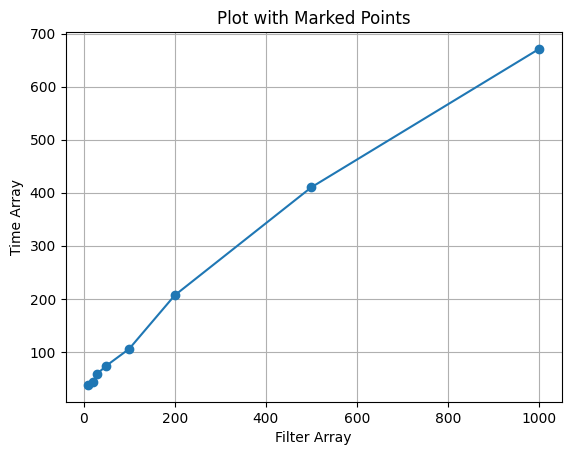

In [12]:
plt.plot(filter_arr, time_arr, marker='o', linestyle='-')  # 'o' marker style with solid line
plt.xlabel('Filter Array')
plt.ylabel('Time Array')
plt.title('Plot with Marked Points')
plt.grid(True)  # Add grid lines
plt.show()